In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable

from model.alexnet import AlexNet
from model.autoencoder import Autoencoder
from utils.dataset import DatasetFashion

In [2]:
EPOCHS = 7
BATCH_SIZE = 128
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

classes_labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
    ]

print(torch.__version__)
print(DEVICE)

2.1.2
cpu


In [3]:
Transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_csv = pd.read_csv('data/fashion/fashion-mnist_train.csv')
test_dataset = pd.read_csv('data/fashion/fashion-mnist_test.csv')

train_csv = train_csv[0:3000]
test_dataset = test_dataset[0:500]

train_dataset = train_csv.sample(frac = 0.8)
validation_dataset = train_csv.drop(train_dataset.index)

print(train_dataset.shape)
print(validation_dataset.shape)
print(test_dataset.shape)

(2400, 785)
(600, 785)
(500, 785)


In [5]:
train_loader = DataLoader(DatasetFashion(train_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(DatasetFashion(validation_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(DatasetFashion(test_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)

In [6]:
criterion = F.nll_loss

In [7]:
feature_extr_model = Autoencoder().to(DEVICE)
feature_extr_criterion = nn.MSELoss()
feature_extr_optimizer = torch.optim.AdamW(feature_extr_model.parameters())

In [8]:
def train_encoder(train_loader, epoch, train_losses):
    feature_extr_model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        output = feature_extr_model(data)
        loss = feature_extr_criterion(output, data)
        feature_extr_optimizer.zero_grad()
        loss.backward()
        feature_extr_optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.9f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [9]:
def test_encoder(validation_loader, validation_losses):
    feature_extr_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (data, _) in validation_loader:
            data = data.to(DEVICE)
            output = feature_extr_model(data)
            test_loss += feature_extr_criterion(output, data).item()
            pred = output.max(1, keepdim=True)[1]

        test_loss /= len(validation_loader)  
        validation_losses.append(test_loss)
        print("Validation set: Average loss: {:.9f}\n".format(test_loss))
        print('='*50)

In [10]:
encoder_train_losses = []
encoder_validation_losses = []

for epoch in range(1, EPOCHS+1):
    train_encoder(train_loader, epoch, encoder_train_losses)
    test_encoder(validation_loader, encoder_validation_losses)

Validation set: Average loss: 0.056980609

Validation set: Average loss: 0.022922136

Validation set: Average loss: 0.014420892

Validation set: Average loss: 0.010914341

Validation set: Average loss: 0.008515439

Validation set: Average loss: 0.006933740

Validation set: Average loss: 0.005857734



In [11]:
encoder = feature_extr_model.encoder

In [12]:
def train(model, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [13]:
def test(model, validation_loader, validation_losses, validation_accuracy):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(validation_loader.dataset)  
        validation_losses.append(test_loss)
        validation_accuracy.append(100. * correct / len(validation_loader.dataset))
        print("Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(validation_loader.dataset), 100. * correct / len(validation_loader.dataset)))
        print('='*50)

In [16]:
train_losses = []
validation_losses = []
validation_accuracy = []

model = AlexNet(encoder).to(DEVICE)
for param in model.encoder.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.parameters())

for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, epoch, train_losses)
    test(model, validation_loader, validation_losses, validation_accuracy)

RuntimeError: Given input size: (96x2x2). Calculated output size: (96x0x0). Output size is too small

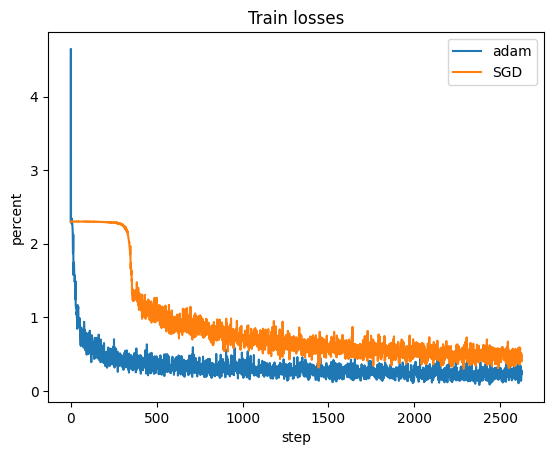

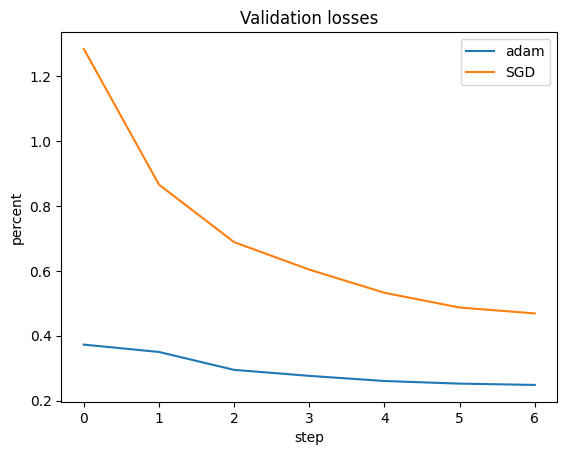

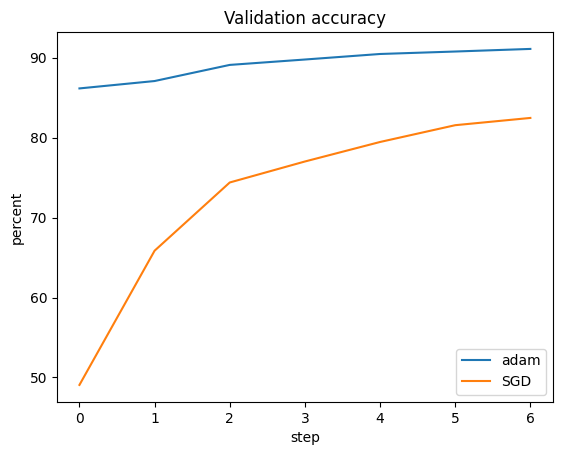

In [15]:
plt.figure()
plt.plot(adam_train_losses, label='adam')
plt.title('Train losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()


plt.figure()
plt.plot(adam_validation_losses, label='adam')
plt.title('Validation losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

plt.figure()
plt.plot(adam_validation_accuracy, label='adam')
plt.title('Validation accuracy')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

Accuracy per class:  [0.9   0.991 0.858 0.928 0.853 0.968 0.717 0.96  0.975 0.972]
Precision per class:  [0.82720588 0.97156863 0.8755102  0.91790307 0.86248736 0.99588477
 0.77513514 0.95238095 0.98385469 0.95669291]
Recall per class:  [0.9   0.991 0.858 0.928 0.853 0.968 0.717 0.96  0.975 0.972]
F1 per class:  [0.86206897 0.98118812 0.86666667 0.92292392 0.85771745 0.98174442
 0.74493506 0.9561753  0.97940733 0.96428571]


<Axes: >

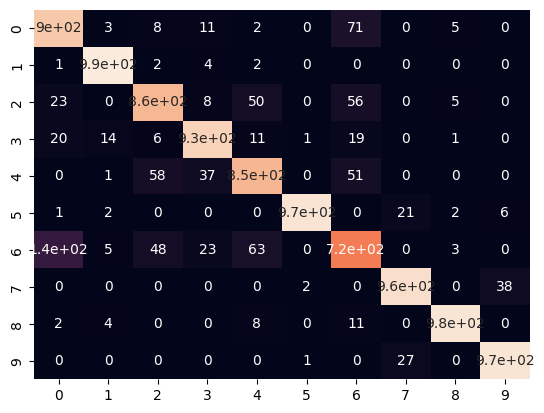

In [16]:
# Adam

adam_model.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = adam_model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

confusion = confusion_matrix(true_labels, predicted_labels)
total_samples_per_class = confusion.sum(axis=1)

print("Accuracy per class: ", confusion.diagonal()/total_samples_per_class)
print("Precision per class: ", precision_score(true_labels,  predicted_labels, average = None))
print("Recall per class: ", recall_score(true_labels,  predicted_labels, average = None))
print("F1 per class: ", f1_score(true_labels,  predicted_labels, average = None))

sns.heatmap(confusion, cbar = False, annot = True)

Accuracy per class:  [0.818 0.958 0.804 0.892 0.692 0.921 0.385 0.924 0.958 0.941]
Precision per class:  [0.7525299  0.97655454 0.62910798 0.81535649 0.74972914 0.93788187
 0.65143824 0.88590604 0.93829579 0.941     ]
Recall per class:  [0.818 0.958 0.804 0.892 0.692 0.921 0.385 0.924 0.958 0.941]
F1 per class:  [0.78390034 0.96718829 0.70588235 0.85195798 0.71970879 0.92936428
 0.48397234 0.90455213 0.94804552 0.941     ]


<Axes: >

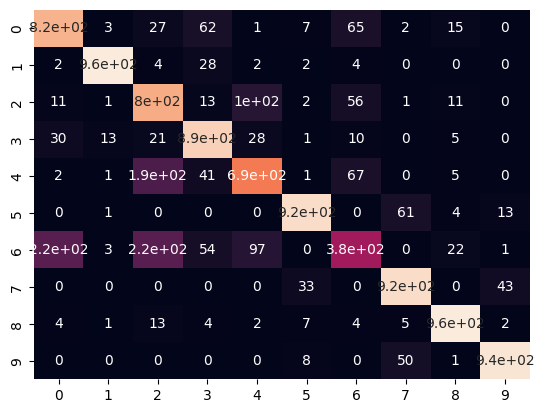

In [17]:
# SGD

sgd_model.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = sgd_model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

confusion = confusion_matrix(true_labels, predicted_labels)
total_samples_per_class = confusion.sum(axis=1)

print("Accuracy per class: ", confusion.diagonal()/total_samples_per_class)
print("Precision per class: ", precision_score(true_labels,  predicted_labels, average = None))
print("Recall per class: ", recall_score(true_labels,  predicted_labels, average = None))
print("F1 per class: ", f1_score(true_labels,  predicted_labels, average = None))

sns.heatmap(confusion, cbar = False, annot = True)

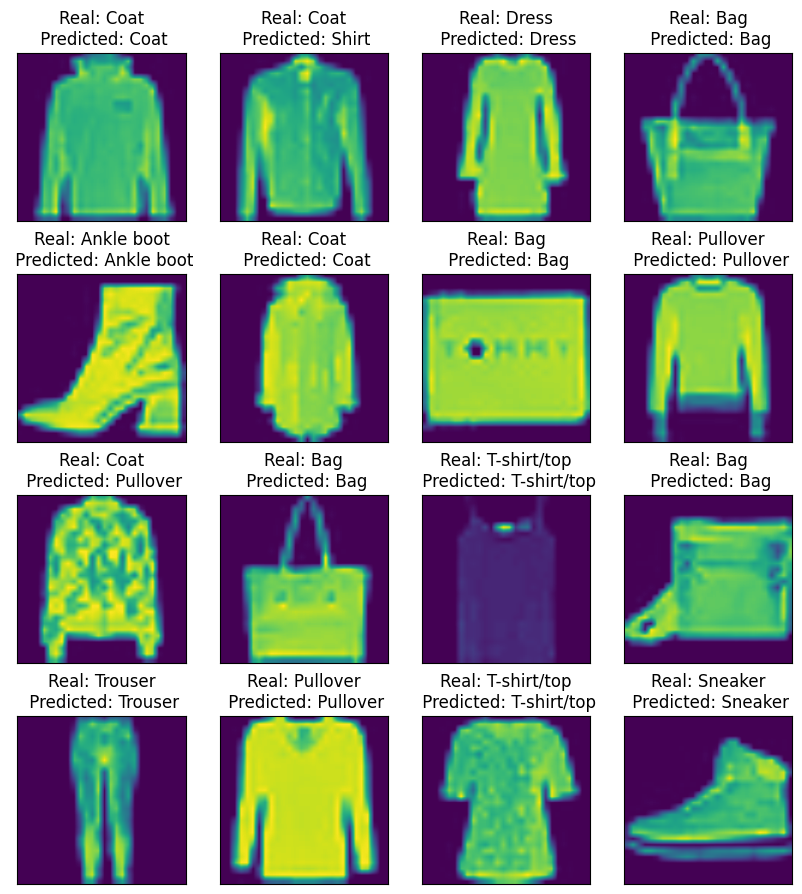

In [20]:
fig = plt.figure(figsize=(10, 11))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = np.transpose(np.array(images[i].to('cpu')), (1,2,0))
    plt.imshow(img/2 + 0.5)
    real_label = classes_labels[labels[i].item()]
    predicted_label = classes_labels[predicted[i].item()]
    ax.set_title(f"Real: {real_label}\n Predicted: {predicted_label}")

plt.show()